# Requirement
numpy==1.23.4

pandas==1.5.3

tensorflow==2.10.1

tqdm==4.65.0

# import library & parameters


In [1]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import jieba
import re
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

### Control tensorflow won't occupied all your GPU memory
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
### Configs --> Parameters you can attempt to tuning
MAXLEN = 50 # If you data has short sentence, please try lower MAXLEN in order to increase performance of model training
EPOCHS = 20
BATCH_SIZE = 64
EMB_DIM = 200
UNIT = 256
example = 53

# load Data

In [2]:
!git clone https://github.com/doudou030/C_Chat_Chatbot.git
!cp C_Chat_Chatbot/train_data/train.txt train.txt
!cp C_Chat_Chatbot/train_data/train.json train.json

Cloning into 'C_Chat_Chatbot'...
remote: Enumerating objects: 48, done.
remote: Counting objects: 100% (48/48), done.
remote: Compressing objects: 100% (43/43), done.
remote: Total 48 (delta 12), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (48/48), 15.52 MiB | 4.48 MiB/s, done.


In [3]:
q_data = []
a_data = []
f = open('/content/train.txt')
lines = f.readlines() #總共行數
for line in lines:
    line = line.strip()
    if line.startswith('Q:'):
        q_data.append(line[3:])
    elif line.startswith('A:'):
        a_data.append(line[3:])
f.close

# 如果說第一個有空格就去掉
for i in range(len(q_data)):
  q_data[i] = q_data[i].lstrip()
  a_data[i] = a_data[i].lstrip()

# 用jieba去掉一些不必要的字
# print("original :" + q_data[example])
for i in range(len(q_data)):
  q_data[i] = jieba.lcut(q_data[i])
  q_data[i] = [q_data[i] for q_data[i] in q_data[i] if re.match(r'^[\u4e00-\u9fa5a-zA-Z0-9]+$', q_data[i])]
  q_data[i] = ''.join(q_data[i])
  a_data[i] = jieba.lcut(a_data[i])
  a_data[i] = [a_data[i] for a_data[i] in a_data[i] if re.match(r'^[\u4e00-\u9fa5a-zA-Z0-9]+$', a_data[i])]
  a_data[i] = ''.join(a_data[i])
# print("這是jieba的 :" + q_data[example])

# 轉成nparray並打亂
q_data = np.array(q_data)
a_data = np.array(a_data)
q_data, a_data = shuffle(q_data,a_data)

q, a = [], []
for i in range(len(q_data)):
  seq_q, seq_a = q_data[i], a_data[i]
  q.append("".join(seq_q))
  a.append("".join(seq_a))

for i in range(5):
  print(q[i])
  print(a[i])

Building prefix dict from the default dictionary ...
DEBUG:jieba:Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
DEBUG:jieba:Dumping model to file cache /tmp/jieba.cache
Loading model cost 0.867 seconds.
DEBUG:jieba:Loading model cost 0.867 seconds.
Prefix dict has been built successfully.
DEBUG:jieba:Prefix dict has been built successfully.


有沒有幸運會心爆擊流的角色
怕傷害不夠的我把爆率也稱滿了
床上有個蘿莉
請問這是AI畫的嗎
有多少人把終局之戰當成MCU的結局了
也差不多了新出的都
閃電霹靂車comingsoon
SEED劇場版確定會出了嗎
2023動畫瘋冬季榜第八週
真不愧是暗影大人


In [4]:
print(len(q))
print(len(a))

49478
49478


# Tokenizer

In [5]:
### Build character-based vocabulary
def tokenize_chinese(texts, voc, voc_ind):
    for t in tqdm(texts):
        for ch in str(t):
            if ch not in voc:
                voc[ch] = voc_ind
                voc_ind += 1
    return voc, voc_ind

In [6]:
voc = {} # Vocabulary dictionary
voc_ind = 1 # vocabulary index start from 1, index 0 means nothing

voc, voc_ind = tokenize_chinese(q, voc, voc_ind)
voc, voc_ind = tokenize_chinese(a, voc, voc_ind)

100%|██████████| 49478/49478 [00:00<00:00, 666024.07it/s]


# data preprocessing

In [7]:
def fit_sentence(sen, voc):
    res = []
    for i in sen:
        res.append(voc[i])
    return res

In [8]:
### Insert "Start Of Sentence" token into vocabulary
voc["<SOS>"] = len(voc)+1
### Insert "End Of Sentence" token into vocabulary
voc["<EOS>"] = len(voc)+1

In [9]:
q_x = []
ans_x, ans_y = [], []

In [10]:
### Question input
for i in tqdm(q):
    res = fit_sentence(i, voc)
    while len(res) < MAXLEN: ### If sentence is shorter than maxlen, append 0 until length reach maxlen
        res.append(0)
    q_x.append(res)

100%|██████████| 49478/49478 [00:00<00:00, 95404.67it/s]


In [11]:
### Answer input
for i in tqdm(a):
    res = fit_sentence(i, voc)
    res.insert(0,voc["<SOS>"])
    res.append(voc["<EOS>"])
    while len(res) < MAXLEN: ### If sentence is shorter than maxlen, append 0 until length reach maxlen
        res.append(0)
    ans_x.append(res)

100%|██████████| 49478/49478 [00:00<00:00, 57132.30it/s]


In [12]:
### Answer output
for i in ans_x:
    tmp = i[1:]
    tmp.append(0)
    ans_y.append(tmp)

In [13]:
### Turn into np.array for training
q_x = np.array(q_x)
ans_x = np.array(ans_x)
ans_y = np.array(ans_y)

# Model

In [14]:
def build_model(voc):
    Q_in = Input((MAXLEN,),name='Q_input')
    Q_emb = Embedding(len(voc)+1,EMB_DIM,mask_zero=True,name='Q_emb')(Q_in)
    Q_out, Q_h, Q_c = LSTM(UNIT,return_state=True,recurrent_dropout=0.2,name='Q_LSTM')(Q_emb)
    Q_state = [Q_h,Q_c]
    A_in = Input((MAXLEN,),name='A_input')
    A_emb = Embedding(len(voc)+1,EMB_DIM,mask_zero=True,name='A_emb')(A_in)
    A_out = LSTM(UNIT,return_sequences=True,recurrent_dropout=0.2,name='A_LSTM')(A_emb,initial_state=Q_state)
    output = Dense(len(voc)+1,activation='softmax',name='Output')(A_out)

    model = Model(inputs=[Q_in,A_in],outputs=output,name='ChatBot')

    return model

Model: "ChatBot"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Q_input (InputLayer)           [(None, 50)]         0           []                               
                                                                                                  
 A_input (InputLayer)           [(None, 50)]         0           []                               
                                                                                                  
 Q_emb (Embedding)              (None, 50, 200)      891000      ['Q_input[0][0]']                
                                                                                                  
 A_emb (Embedding)              (None, 50, 200)      891000      ['A_input[0][0]']                
                                                                                            

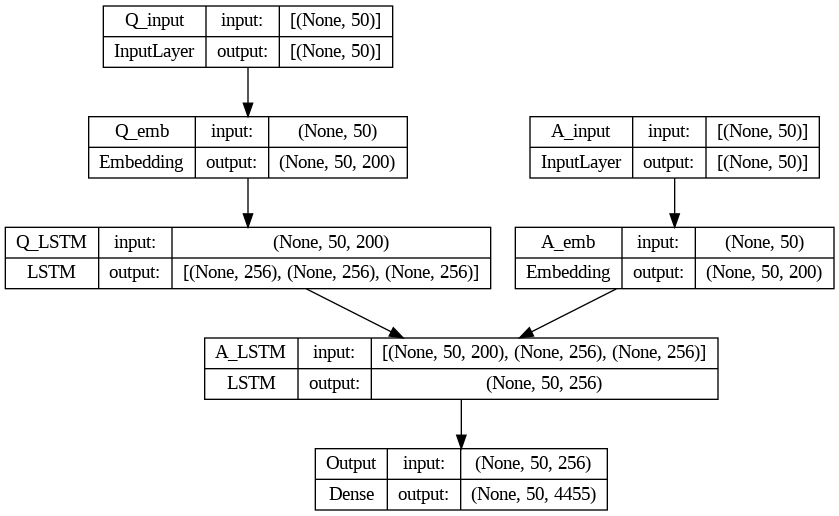

In [15]:
model = build_model(voc)
model.summary()
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
tf.keras.utils.plot_model(model,show_shapes=True)


In [16]:
### Callbacks --> Checkpoint: Change file path to the directory where you want to save your model
checkpoint = ModelCheckpoint(filepath="'chatbot.h5'", monitor='accuracy',verbose=1,save_best_only=True,save_weights_only=True)
### Callbacks --> Earlystop: Monitor accuracy and decide whether to stop the training procedure
earlystop = EarlyStopping(monitor='accuracy',patience=3,verbose=1)

### If you have model trained before, you can load it back and continue previous training procedure
try:
    model.load_weights('chatbot.h5')
    print("Load model...")
### If you haven't train any model yet, train model from initial
except:
    print("Fail to load pretrained model...")

### Train your mode l
model.fit((q_x, ans_x), ans_y, batch_size=BATCH_SIZE,epochs=EPOCHS,callbacks=[checkpoint, earlystop],verbose=1)

Fail to load pretrained model...
Epoch 1/20
49/49 [==============================] - ETA: 0s - loss: 6.5325 - accuracy: 0.0944 
Epoch 1: accuracy improved from -inf to 0.09443, saving model to 'chatbot.h5'
49/49 [==============================] - 1020s 21s/step - loss: 6.5325 - accuracy: 0.0944
Epoch 2/20
49/49 [==============================] - ETA: 0s - loss: 5.6906 - accuracy: 0.1377 
Epoch 2: accuracy improved from 0.09443 to 0.13772, saving model to 'chatbot.h5'
49/49 [==============================] - 1027s 21s/step - loss: 5.6906 - accuracy: 0.1377
Epoch 3/20
49/49 [==============================] - ETA: 0s - loss: 5.4882 - accuracy: 0.1872 
Epoch 3: accuracy improved from 0.13772 to 0.18717, saving model to 'chatbot.h5'
49/49 [==============================] - 1019s 21s/step - loss: 5.4882 - accuracy: 0.1872
Epoch 4/20
49/49 [==============================] - ETA: 0s - loss: 5.3790 - accuracy: 0.1914 
Epoch 4: accuracy improved from 0.18717 to 0.19136, saving model to 'chatbot.

In [17]:
model.save('chatbot.h5')

# Inference

In [18]:
import os
import numpy as np
import pandas as pd

os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
### Configs
MAXLEN = 32 ### MAXLEN should be same as the MAXLEN you use in previous training


In [19]:
def load_model():
    voc = {} # Vocabulary dictionary
    voc_ind = 1 # vocabulary index start from 1, index 0 means nothing
    ### Import your training data for re-build vocabulary
    q_data = []
    a_data = []
    f = open('/content/train.txt')
    lines = f.readlines() #總共行數
    for line in lines:
        line = line.strip()
        if line.startswith('Q:'):
            q_data.append(line[3:])
        elif line.startswith('A:'):
            a_data.append(line[3:])
    f.close

    # 如果說第一個有空格就去掉
    for i in range(len(q_data)):
      q_data[i] = q_data[i].lstrip()
      a_data[i] = a_data[i].lstrip()

    # 用jieba去掉一些不必要的字
    for i in range(len(q_data)):
      q_data[i] = jieba.lcut(q_data[i])
      q_data[i] = [q_data[i] for q_data[i] in q_data[i] if re.match(r'^[\u4e00-\u9fa5a-zA-Z0-9]+$', q_data[i])]
      q_data[i] = ''.join(q_data[i])
      a_data[i] = jieba.lcut(a_data[i])
      a_data[i] = [a_data[i] for a_data[i] in a_data[i] if re.match(r'^[\u4e00-\u9fa5a-zA-Z0-9]+$', a_data[i])]
      a_data[i] = ''.join(a_data[i])

    # 轉成nparray並打亂
    q_data = np.array(q_data)
    a_data = np.array(a_data)
    q_data, a_data = shuffle(q_data,a_data)

    q, a = [], []
    for i in range(len(q_data)):
      seq_q, seq_a = q_data[i], a_data[i]
      q.append("".join(seq_q))
      a.append("".join(seq_a))

    ### Re-build vocabulary
    voc, voc_ind = tokenize_chinese(q, voc, voc_ind)
    voc, voc_ind = tokenize_chinese(a, voc, voc_ind)
    voc["<SOS>"] = len(voc)+1
    voc["<EOS>"] = len(voc)+1
    ind_voc = {}
    for k, v in voc.items():
        ind_voc[v] = k

    ### Build model and load the weight
    model = build_model(voc)
    model.load_weights('/content/chatbot.h5')

    return voc, ind_voc, model

voc, ind_voc, model = load_model()

100%|██████████| 49478/49478 [00:00<00:00, 336175.39it/s]


In [20]:
def single_predict(input_text, voc, ind_voc, model):
    ### Answer input initial state --> [<SOS>] --> [4977, 0, 0, 0,...]
    ans_input = np.zeros((1,MAXLEN),dtype='int64')
    ans_input[0,0] = voc["<SOS>"]

    ### Convert your question into number label
    res = fit_sentence(input_text, voc)
    while len(res) < MAXLEN: # If sentence is shorter than maxlen, append 0 until length reach maxlen
        res.append(0)
    question = np.array([res])

    ind = 0
    ### Stop condition: 1. Prediction until MAXLEN, 2. Output '<EOS>' or 0
    while (ans_input[0][ind] != voc['<EOS>'] or ans_input[0][ind] != 0) and ind < MAXLEN-1:
        ind += 1
        pred = model.predict([question, ans_input],verbose=0)
        res = np.argmax(pred,axis=-1) # Get highest probabilty index of character in vocabulary
        ans_input[0,ind] = res[0][ind]
    ### Convert prediction into human language
    ans = ""
    # print(ans_input[0][1:])
    for i in ans_input[0][1:]:
        if i == 0 or i == voc['<EOS>']:
            break
        ans += ind_voc[i]
    return str(ans) # Return string --> Send string back to ngrok and forwarding to Line

In [21]:
while True:
        question = input('請說: ')
        if question == '88': ### Input '88' means terminate the chatbot
            print('再見')
            break
        res = single_predict(question, voc, ind_voc, model)
        print(res)

請說: 我推
社想社
請說: 床上有個蘿莉
美哀社美哀
請說: 2023動畫瘋
美哀社美哀
請說: 88
再見
